In [148]:
import pandas as pd
import numpy as np
import math
import datetime
import yfinance as yf

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [2]:
# Retrieve data

In [3]:
def get_ticker_data(symbol, period):
    '''
        Arguments:
            symbol --> Security symbol (str)
            period --> number of years (past x years) (int)
    '''   
    symbol = symbol.upper()
    period = str(period)+'y'

    stocks = yf.Ticker(symbol).history(period=period)    
    df = pd.DataFrame(stocks)
    return df

In [150]:
# Clean/Modify Data

In [9]:
def clean_data(df):
    ind = []
    open_col = []
    high = []
    low = []
    close = []
    vol = []
    
    for i in range(len(df)):
        open_col.append(df['Open'][i])
        high.append(df['High'][i])
        low.append(df['Low'][i])
        close.append(df['Close'][i])
        vol.append(df['Volume'][i])
        
    stocks = pd.DataFrame()
    stocks['Open'] = open_col
    stocks['High'] = high
    stocks['Low'] = low
    stocks['Close'] = close
    stocks['Volume'] = vol
    
    return stocks

In [12]:
def normalize_data(df, columns):
    for column in columns:
        temp = []
        min_value = min(df[column])
        max_value = max(df[column])
        for i in range(len(df)):
            temp.append((df[column][i] - min_value) / (max_value - min_value))
        df[column] = temp
    return df
            

In [149]:
# Prepare Data For Model

In [45]:
def prepare_sets(df):
    y = pd.DataFrame()
    y['y'] = df['Close']
    y = y.to_numpy()
    
    x = df.drop(['Close'], axis=1)
    x = x.to_numpy()
    return x, y

In [64]:
def split_data(x, y, prediction_period=1, sequence_length=50, test_data_size=0.2):
    test_data_cut = int(test_data_size * len(x)) + sequence_length + 1
    
    # Training data
    X_train = x[0:-prediction_period - test_data_cut]
    y_train = y[prediction_period:-test_data_cut]
    
    # Test data
    X_test = x[-test_data_cut : -prediction_period]
    y_test = y[prediction_period - test_data_cut:]
    
    return X_train, y_train, X_test, y_test

In [58]:
def prepare_sequences(inputs, outputs, sequence_length=50):
    x = []
    y = []
    
    for i in range(len(inputs)-sequence_length):
        x.append(inputs[i:i+sequence_length])
        y.append(outputs[i+sequence_length])
        
    return np.asarray(x), np.asarray(y)

In [151]:
# LSTM Model

In [20]:
def mean_squared_error(outputs, targets):
    squares_sum = 0
    for i in range(len(outputs)):
        squares_sum += (output[i] - targets[i])**2
    mse = float(squares_sum/len(outputs))
    return mse

In [84]:
def lstm(input_dim, output_dim):
    print(f'{input_dim}, {output_dim}')
    model = Sequential()
    model.add(LSTM(
        input_shape = (None, input_dim),
        units = output_dim,
        return_sequences=True))
    model.add(LSTM(
        100, 
        return_sequences=False))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    return model

In [119]:
def lstm_updated(input_dim, output_dim):
    model = Sequential()
    model.add(LSTM(
        input_shape=(None, input_dim),
        units=output_dim,
        return_sequences=True))

    model.add(Dropout(0.2))

    model.add(LSTM(
        128,
        return_sequences=False))

    model.add(Dropout(0.2))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    return model

In [117]:
def plot_predictions(predictions, targets):
    figure = plt.figure()
    figure.set_figwidth(18)
    figure.set_figheight(10)
    
    plt.plot(targets, '#00FF00', label='targets')
    plt.plot(predictions, '#0000FF', label='predictions')
    
    plt.show()

In [152]:
# Consolidate

In [146]:
def main_loop():
    
    # Data Preparation
    data = get_ticker_data('GOOGL', 10)
    data = clean_data(data)
    data = normalize_data(data, ['Open', 'High', 'Low', 'Close', 'Volume'])
    
    X, y = prepare_sets(data)
    train_in, train_out, test_in, test_out = split_data(X, y)

    X_train, y_train = prepare_sequences(train_in, train_out)
    X_test, y_test = prepare_sequences(test_in, test_out)
    
    print(f'{len(X_train)}, {len(X_test)}')
    print(f'{X_train.shape}, {y_train.shape}, {X_test.shape}, {y_train.shape}')
    
    # Model
    model = lstm_updated(train_inputs.shape[-1], train_inputs.shape[-2])
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Train
    model.fit(
        train_inputs,
        train_outputs,
        batch_size=100,
        epochs=5,
        verbose=2,
        validation_split=0.05)
    
    # Predict
    predictions = model.predict(test_inputs, batch_size=100)
    
    # Plot
    plot_predictions(predictions, test_outputs)
    

10y
1912, 503
(1912, 50, 4), (1912, 1), (503, 50, 4), (1912, 1)
Epoch 1/5
19/19 - 5s - loss: 0.0016 - val_loss: 5.0721e-05 - 5s/epoch - 256ms/step
Epoch 2/5
19/19 - 1s - loss: 1.3692e-04 - val_loss: 1.4648e-04 - 1s/epoch - 75ms/step
Epoch 3/5
19/19 - 1s - loss: 9.0915e-05 - val_loss: 6.5400e-05 - 1s/epoch - 75ms/step
Epoch 4/5
19/19 - 1s - loss: 7.1039e-05 - val_loss: 4.2487e-05 - 1s/epoch - 74ms/step
Epoch 5/5
19/19 - 1s - loss: 7.4442e-05 - val_loss: 4.0039e-05 - 1s/epoch - 76ms/step


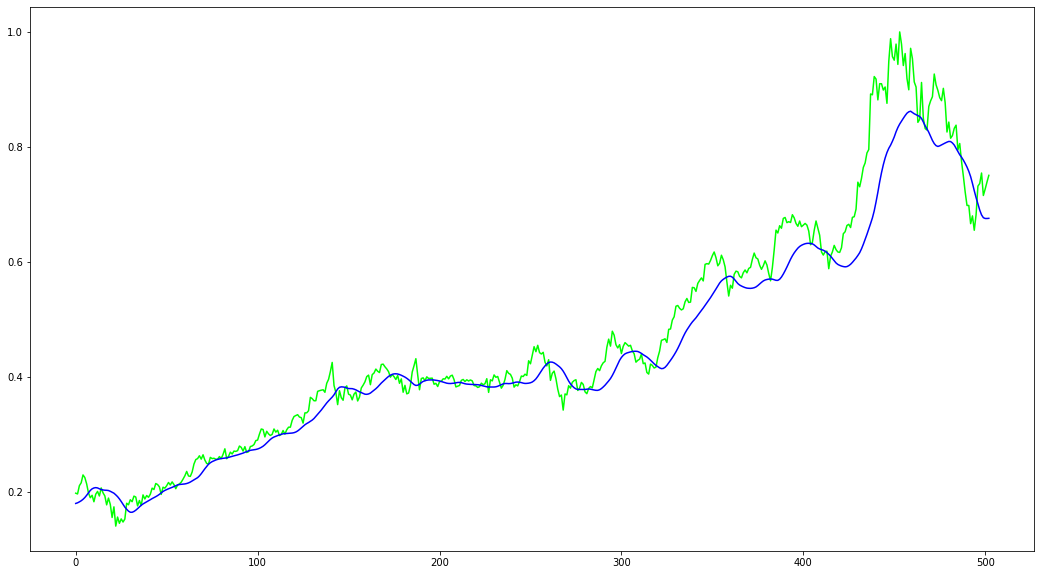

In [147]:
main_loop()